## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src import calibration, utils
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Camera Calibration

* camera calibrated
* chess-board image can be undistorted
* perspective transform can be applied to chess-board image
* perspective transform applied to road image

In [46]:
camera = calibration.Camera()
camera.calibrate(False)

WARNING Not all corners were found in camera_cal/calibration5.jpg, skipping...
WARNING Not all corners were found in camera_cal/calibration4.jpg, skipping...
WARNING Not all corners were found in camera_cal/calibration1.jpg, skipping...


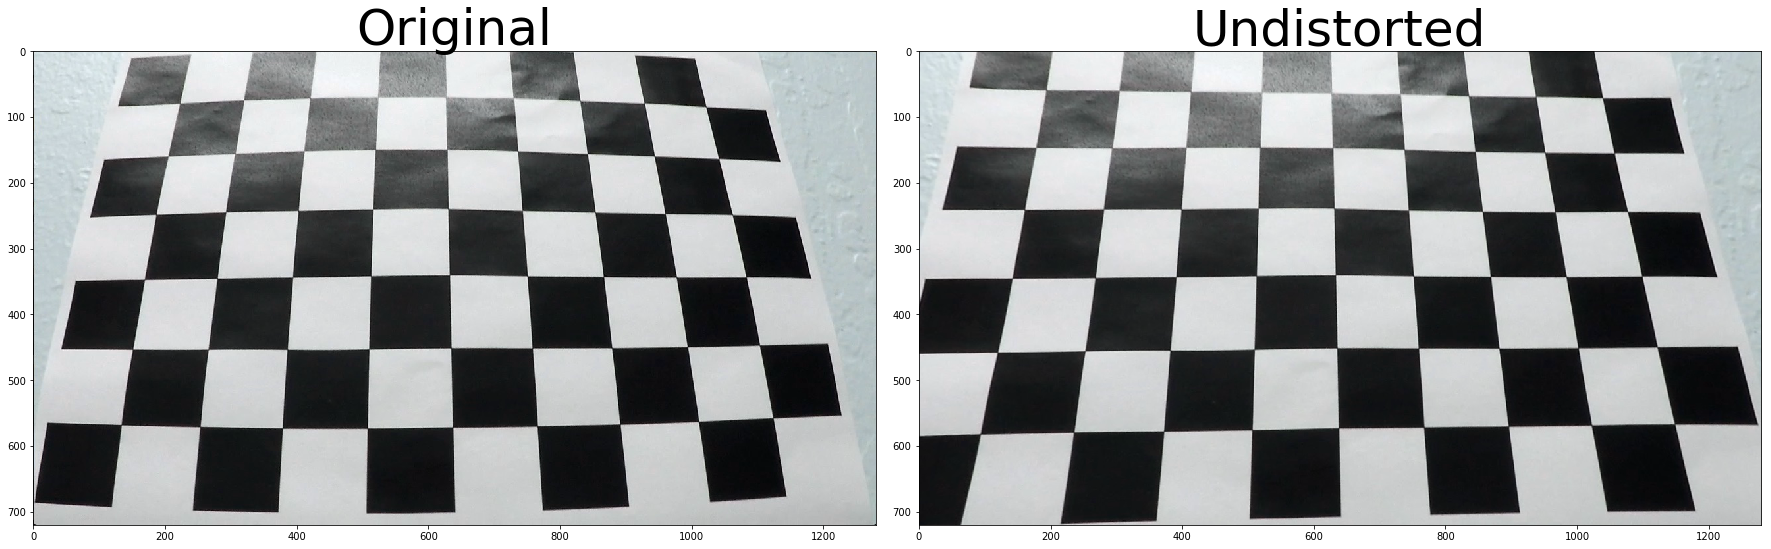

In [47]:
image_filename = 'examples/chess-board.jpg'
img = cv2.imread(image_filename)

undistorted = camera.undistort(img)

utils.display_two_images(img, 'Original', undistorted, 'Undistorted')

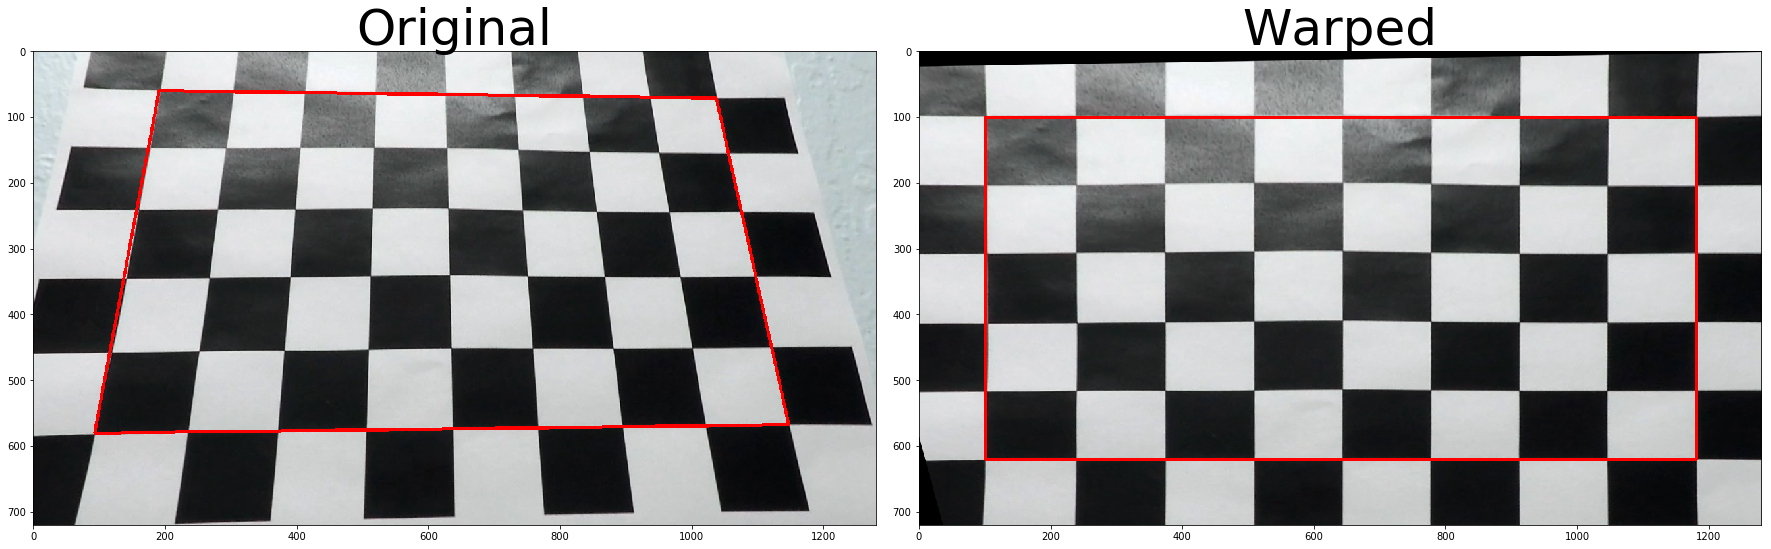

In [108]:
image_filename = 'examples/chess-board.jpg'
img = cv2.imread(image_filename)

src, dst = camera.find_chess_board_perspective_transform_pts(img, 100)
overlaid, warped, _ = camera.perspective_transform(img, src, dst)

utils.display_two_images(overlaid, 'Original', warped, 'Warped')

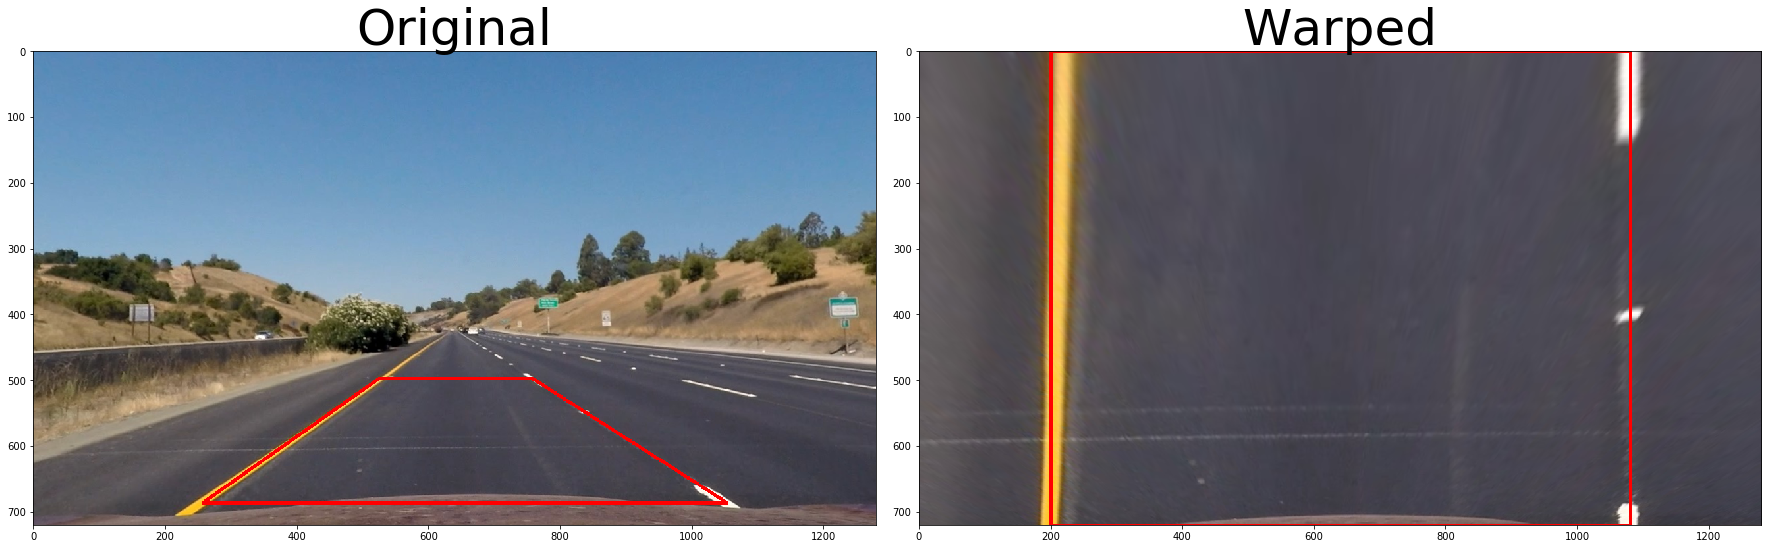

In [115]:
image_filename = 'examples/straight_lines1.jpg'
img = mpimg.imread(image_filename)

height, width, _ = img.shape
offset = 200
src = np.array([[257,686],[1054, 686], [758, 497], [525, 497]], dtype=np.float32)
dst = np.array([[offset, height], [width-offset, height], [width - offset, 0], [offset, 0]], dtype=np.float32)

overlaid, warped, _ = camera.perspective_transform(img, src, dst)

utils.display_two_images(overlaid, 'Original', warped, 'Warped')